In [1]:
# Run this code to unzip the Skin Diseases Data into a "dataset" folder
import zipfile as zf
files = zf.ZipFile("archive.zip", 'r')
files.extractall('dataset')
files.close()

In [46]:
# Useful Imports

# Torch Imports
import torch
import torch.nn as nn
import torch.utils.data as data

# Torchvision Imports
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Utility Imports
import matplotlib.pyplot as plt
import numpy as np

# Metric and Matrix Imports
#!pip install seaborn
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, accuracy_score

# Bayesian Optimization Imports
#!pip install GPy
#!pip install GPyOpt
import GPyOpt

In [47]:
# Converts every image to 256x256 dimension, randomly change images for generalization,
# into a tensor, normalize pixel values
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Converts every image to 256x256 dimension and into a Tensor
val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Loads each subset directory from your "dataset" folder
train_dataset = datasets.ImageFolder(root='dataset/Train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='dataset/Test', transform=val_test_transform)
val_dataset = datasets.ImageFolder(root='dataset/Val', transform=val_test_transform)

# Hyper Parameters for dataset organization and processing
batch_size = 100
num_workers = 3
# Dataloader for each subset which will batch, shuffle, and parallel load the data
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [5]:
# Total images in each subset
print('Train data: ', len(train_dataset))
print('Test data: ', len(test_dataset))
print('Valid data: ', len(val_dataset))

Train data:  1198
Test data:  389
Valid data:  250


In [6]:
# distribution of classes across datasets:
# https://discuss.pytorch.org/t/how-to-see-distribution-of-labels-in-dataset/158379
from collections import Counter
train_labels = dict(Counter(train_dataset.targets))
val_labels = dict(Counter(val_dataset.targets))
test_labels = dict(Counter(test_dataset.targets))

print(train_labels.values())
print(val_labels.values())
print(test_labels.values())

diseases = ['Herpes', 'Melanoma', 'Monkeypox', 'Sarampion', 'Varicela']

dict_values([250, 300, 248, 200, 200])
dict_values([50, 50, 50, 50, 50])
dict_values([86, 100, 88, 43, 72])


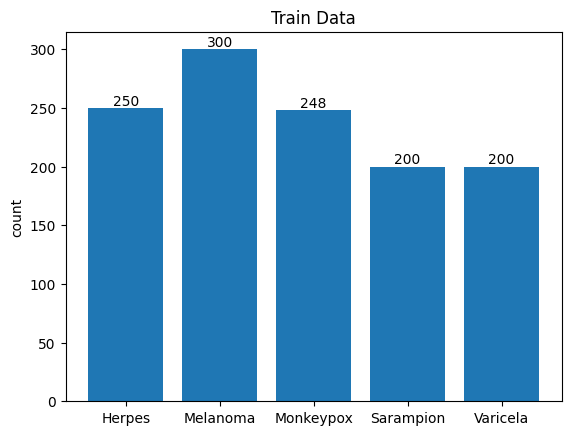

In [7]:
fig_train, ax_train = plt.subplots()
p_train = ax_train.bar(diseases, train_labels.values())
ax_train.bar_label(p_train)
ax_train.set_ylabel('count')
ax_train.set_title('Train Data')
plt.show()

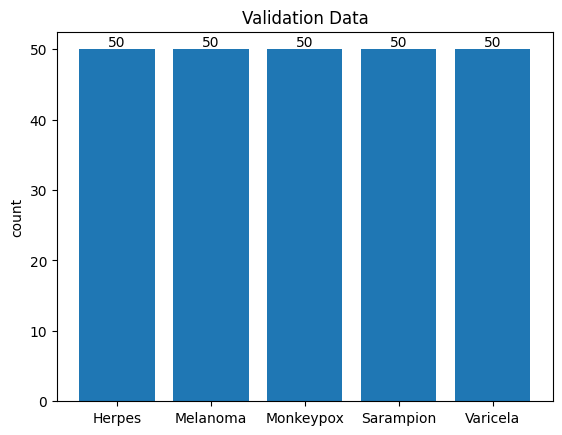

In [8]:
fig_val, ax_val = plt.subplots()
p_val = ax_val.bar(diseases, val_labels.values())
ax_val.bar_label(p_val)
ax_val.set_ylabel('count')
ax_val.set_title('Validation Data')
plt.show()

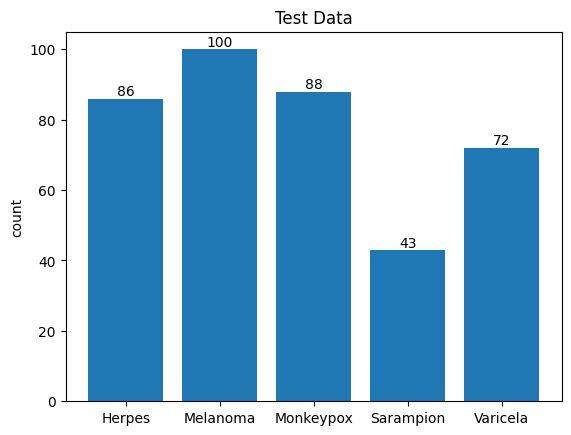

In [9]:
fig_test, ax_test = plt.subplots()
p_test = ax_test.bar(diseases, test_labels.values())
ax_test.bar_label(p_test)
ax_test.set_ylabel('count')
ax_test.set_title('Test Data')
plt.show()

torch.Size([3, 128, 128])
tensor(3)
torch.Size([100, 3, 128, 128])
torch.Size([100])


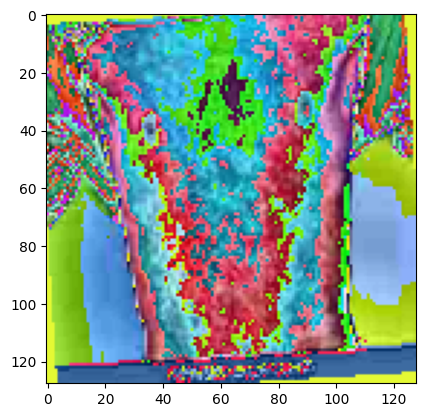

In [10]:
# Check a batch of data
images, labels = next(iter(train_dataloader))

print(images[0].size()) # Number of Colors (RGB=3), Height=256, Width=256
print(labels[0]) # Herpes=0, Melanoma=1, Monkeypox=2, Sarampion=3, Varicela=4
print(images.shape)
print(labels.shape)

# Will show the image sampled
image = transforms.ToPILImage()(images[0])
plt.imshow(image)
plt.show()

In [11]:
# Calculates output layer size, convenient when making multiple hidden layers
def output_size(in_channels, kernel_size, padding, stride, pool):
    # Ensure the result is at least 1 to avoid negative or zero dimensions
    return max(1, np.floor((((in_channels - kernel_size + (2 * padding)) / stride) + 1) / pool))

# Test Run of output_size
output_shape = output_size(128, 3, 0, 1, 2)
print(output_shape)

63.0


In [12]:
# Allows model to run on GPU if it is present
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
print(device)

cpu


In [14]:
# Define a train_model function
def train_model(model, criterion, optimizer, epochs):
    total_step = len(train_dataloader)
    
    for epoch in range(epochs):
        loss_per_epoch = 0
        for i, (images, labels) in enumerate(train_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_per_epoch += loss.item()
            #print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    #.format(epoch+1, epochs, i+1, total_step, loss.item()))
        print(f"Epoch: {epoch+1}, {loss_per_epoch/total_step}")

In [15]:
# train_model function with accuracy calculation to determine overfitting point
def train_model_with_acc(model, criterion, optimizer, epochs):
    total_step = len(train_dataloader)
    
    for epoch in range(epochs):
        loss_per_epoch = 0
        for i, (images, labels) in enumerate(train_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_per_epoch += loss.item()
            #print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    #.format(epoch+1, epochs, i+1, total_step, loss.item()))
        print(f"Epoch: {epoch+1}, {loss_per_epoch/total_step}")
        calculate_accuracy(model, val_dataloader, device)

In [16]:
# Define a calculate_accuracy function
def calculate_accuracy(model, dataloader, device):
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')

In [17]:
# Produces a confusion matrix, and metrics including Precision, Recall, and F1 Score
def confusion_matrix_and_metrics(model, dataloader, device):
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=dataloader.dataset.classes,
        yticklabels=dataloader.dataset.classes)

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    print("Precision of the MLP :\t"+str(precision_score(y_true, y_pred, average="macro")))
    print("Recall of the MLP    :\t"+str(recall_score(y_true, y_pred, average="macro")))
    print("F1 Score of the Model :\t"+str(f1_score(y_true, y_pred, average="macro")))

In [18]:
# Custom CNN Model

class CustomCNN(nn.Module):
    def __init__(self, dropout, kernel, channels):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, channels, kernel_size=kernel, stride=1, padding=0), 
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2, stride=2)) 

        output_shape = output_size(128, kernel, 0, 1, 2)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(channels, channels*2, kernel_size=kernel, stride=1, padding=0), 
            nn.BatchNorm2d(channels*2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2, stride=2)) 

        output_shape = output_size(output_shape, kernel, 0, 1, 2)
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(channels*2, channels*4, kernel_size=kernel, stride=1, padding=0), 
            nn.BatchNorm2d(channels*4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2, stride=2)) 

        output_shape = output_size(output_shape, kernel, 0, 1, 2)
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(channels*4, channels*2, kernel_size=kernel, stride=1, padding=0), 
            nn.BatchNorm2d(channels*2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2, stride=2))

        output_shape = output_size(output_shape, kernel, 0, 1, 2)

        self.conv5 = nn.Sequential(
            nn.Conv2d(channels*2, channels, kernel_size=kernel, stride=1, padding=0), 
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2, stride=2))

        output_shape = output_size(output_shape, kernel, 0, 1, 2)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Sequential(
            nn.Linear(channels*int(output_shape)*int(output_shape), channels*2),
            nn.ReLU())

        self.fc2 = nn.Sequential(
            nn.Linear(channels*2, channels),
            nn.ReLU())
        
        self.fc3 = nn.Linear(channels, 5)

    def forward(self, out):
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [19]:
# Test run, should output torch.Size([batch_size, classes])
custom_cnn = CustomCNN(dropout=0.3, kernel=3, channels=32).to(device)
output = custom_cnn(images.to(device))
print(output.size())

torch.Size([100, 5])


In [21]:
custom_cnn = torch.load('trained_custom_cnn.pth', weights_only=False, map_location=torch.device('cpu'))
custom_cnn.eval()

CustomCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 64

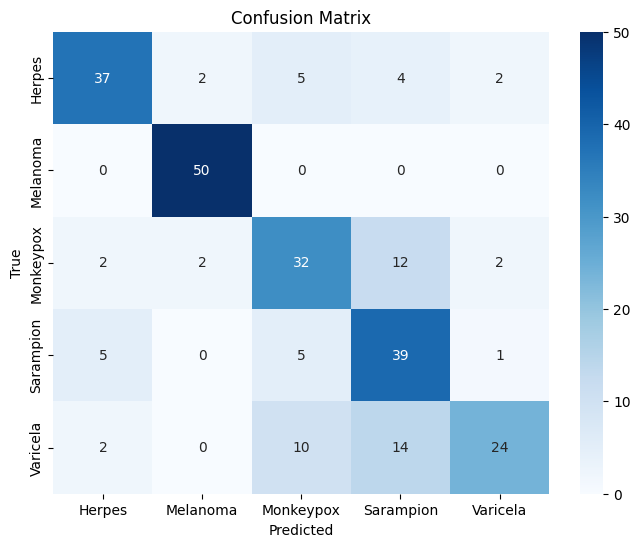

Precision of the MLP :	0.7476923931196795
Recall of the MLP    :	0.728
F1 Score of the Model :	0.7245759793693525
Accuracy: 72.8%


In [22]:
# Calculate Custom CNN Accuracy, Matrix, and Metrics
confusion_matrix_and_metrics(custom_cnn, val_dataloader, device)
calculate_accuracy(custom_cnn, val_dataloader, device)

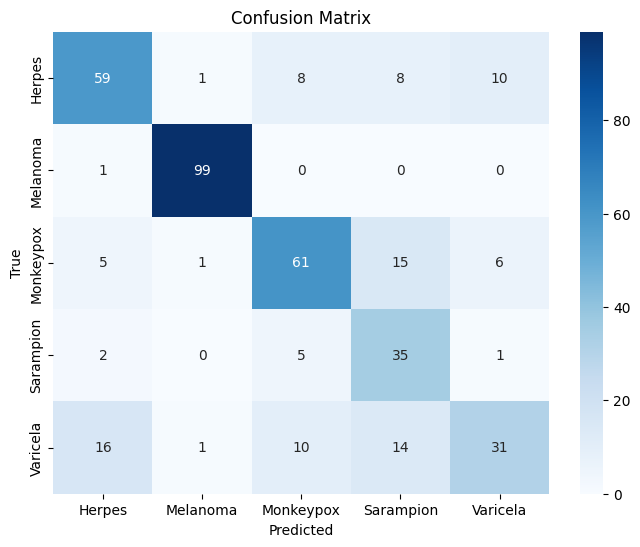

Precision of the MLP :	0.7079133058846029
Recall of the MLP    :	0.7227474747474748
F1 Score of the Model :	0.7026175032589922
Accuracy: 73.26478149100257%


In [23]:
# Test Custom CNN Accuracy, Matrix, and Metrics
confusion_matrix_and_metrics(custom_cnn, test_dataloader, device)
calculate_accuracy(custom_cnn, test_dataloader, device)

In [24]:
# Data organization for ResNet Models
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Loads each subset directory from your "dataset" folder
train_dataset = datasets.ImageFolder(root='dataset/Train', transform=transform)
test_dataset = datasets.ImageFolder(root='dataset/Test', transform=transform)
val_dataset = datasets.ImageFolder(root='dataset/Val', transform=transform)

# Hyper Parameters for dataset organization and processing
batch_size = 25
num_workers = 3
# Dataloader for each subset which will batch, shuffle, and parallel load the data
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [26]:
# Declare ResNet50 Model
resnet_50 = torch.load('trained_resnet_50.pth', weights_only=False, map_location=torch.device('cpu'))
resnet_50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

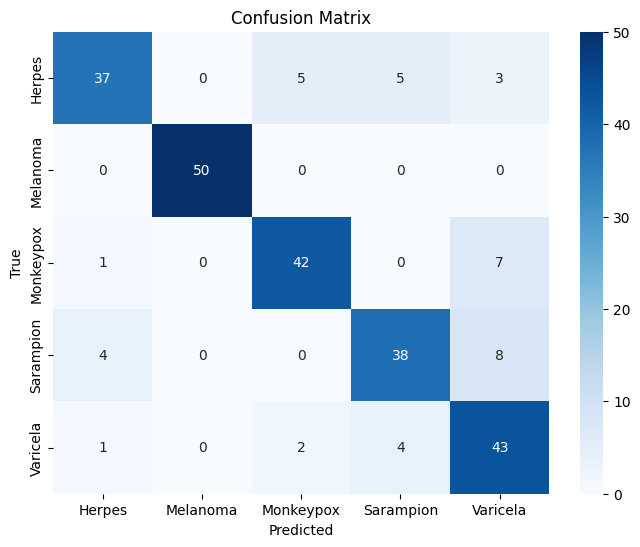

Precision of the MLP :	0.8462073289013368
Recall of the MLP    :	0.8400000000000001
F1 Score of the Model :	0.8404927405259961
Accuracy: 84.0%


In [27]:
# Calculate Validation Accuracy, Matrix, and Metrics
confusion_matrix_and_metrics(resnet_50, val_dataloader, device)
calculate_accuracy(resnet_50, val_dataloader, device)

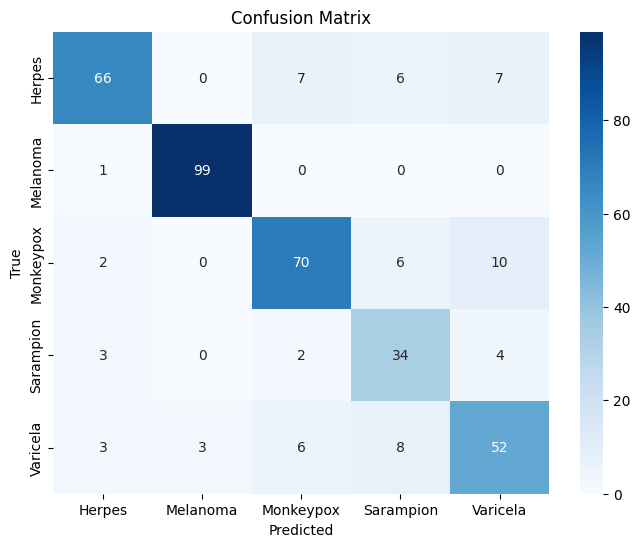

Precision of the MLP :	0.8032152087623482
Recall of the MLP    :	0.8131632605120978
F1 Score of the Model :	0.8055189316516372
Accuracy: 82.51928020565553%


In [28]:
# Calculate Test Accuracy, Matrix, and Metrics
confusion_matrix_and_metrics(resnet_50, test_dataloader, device)
calculate_accuracy(resnet_50, test_dataloader, device)

In [29]:
# Data organization for AlexNet model
# do we need consistent shuffle across different models? (will it affect model evaluation?)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Loads each subset directory from your "dataset" folder
train_dataset = datasets.ImageFolder(root='dataset/Train', transform=transform)
test_dataset = datasets.ImageFolder(root='dataset/Test', transform=transform)
val_dataset = datasets.ImageFolder(root='dataset/Val', transform=transform)

# Hyper Parameters for dataset organization and processing
batch_size = 25
num_workers = 3
# Dataloader for each subset which will batch, shuffle, and parallel load the data
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [30]:
# Declare AlexNet model
alexnet_SGD = torch.load('trained_alexnet_SGD.pth', weights_only=False, map_location=torch.device('cpu'))
alexnet_SGD.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

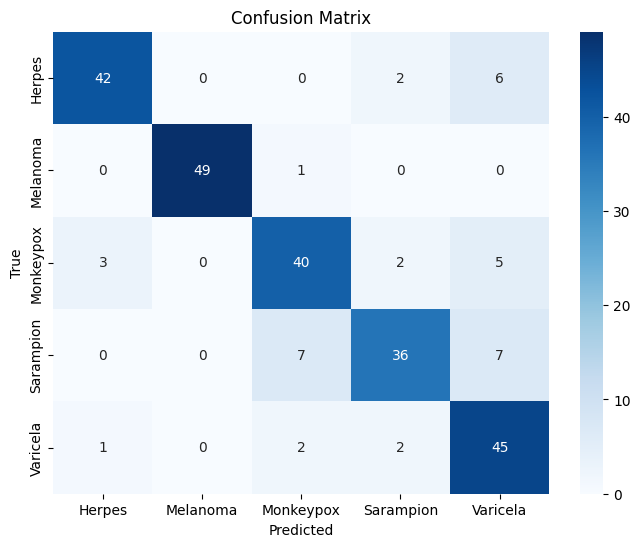

Precision of the MLP :	0.8568944099378882
Recall of the MLP    :	0.8480000000000001
F1 Score of the Model :	0.8487935725084629
Accuracy: 84.8%


In [31]:
# Calculate Validation Accuracy, Matrix, and Metrics with SGD optimizer
confusion_matrix_and_metrics(alexnet_SGD, val_dataloader, device)
calculate_accuracy(alexnet_SGD, val_dataloader, device)

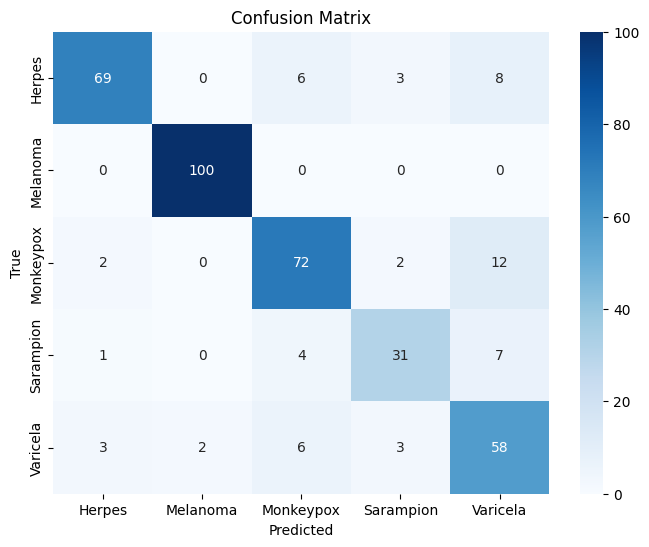

Precision of the MLP :	0.8391597422185658
Recall of the MLP    :	0.8293986375381724
F1 Score of the Model :	0.8320749498771978
Accuracy: 84.83290488431876%


In [32]:
# Calculate Test Accuracy, Matrix, and Metrics with SGD optimizer
confusion_matrix_and_metrics(alexnet_SGD, test_dataloader, device)
calculate_accuracy(alexnet_SGD, test_dataloader, device)

In [33]:
# Declare another Alex Net Model to use Adam optimizer
alexnet_Adam = torch.load('trained_alexnet_Adam.pth', weights_only=False, map_location=torch.device('cpu'))
alexnet_Adam.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

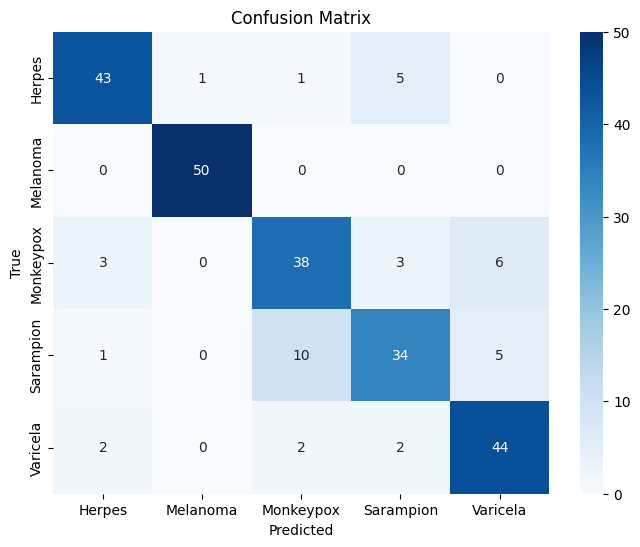

Precision of the MLP :	0.8351536978427735
Recall of the MLP    :	0.8360000000000001
F1 Score of the Model :	0.8345521239053996
Accuracy: 83.6%


In [34]:
# Calculate Validation Accuracy, Matrix, and Metrics with Adam optimizer
confusion_matrix_and_metrics(alexnet_Adam, val_dataloader, device)
calculate_accuracy(alexnet_Adam, val_dataloader, device)

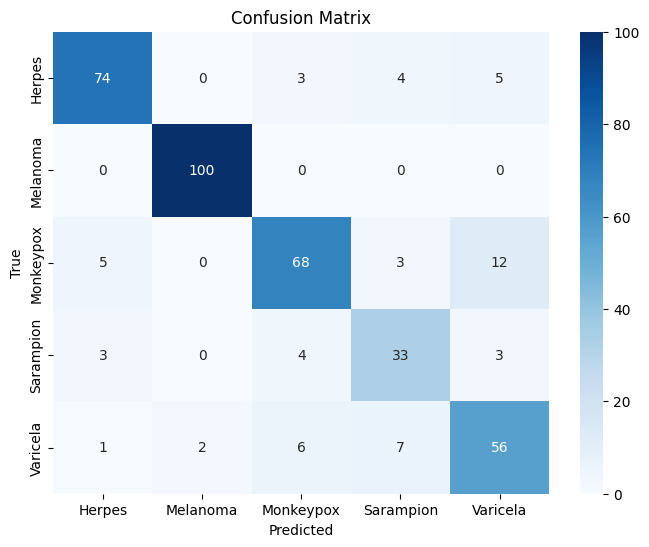

Precision of the MLP :	0.8300868719200235
Recall of the MLP    :	0.8356824054498473
F1 Score of the Model :	0.8321324945544291
Accuracy: 85.08997429305913%


In [35]:
# Calculate Test Accuracy, Matrix, and Metrics with Adam optimizer
confusion_matrix_and_metrics(alexnet_Adam, test_dataloader, device)
calculate_accuracy(alexnet_Adam, test_dataloader, device)

In [51]:
# Data organization for Vision Transformers (ViT) Base Model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Loads each subset directory from your "dataset" folder
train_dataset = datasets.ImageFolder(root='dataset/Train', transform=transform)
test_dataset = datasets.ImageFolder(root='dataset/Test', transform=transform)
val_dataset = datasets.ImageFolder(root='dataset/Val', transform=transform)

# Hyper Parameters for dataset organization and processing
batch_size = 25
num_workers = 3

# Dataloader for each subset which will batch, shuffle, and parallel load the data
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [37]:
# Declare Vision Transformers (ViT) Base Model
vit_b = torch.load('trained_vit_b.pth', weights_only=False, map_location=torch.device('cpu'))
vit_b.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

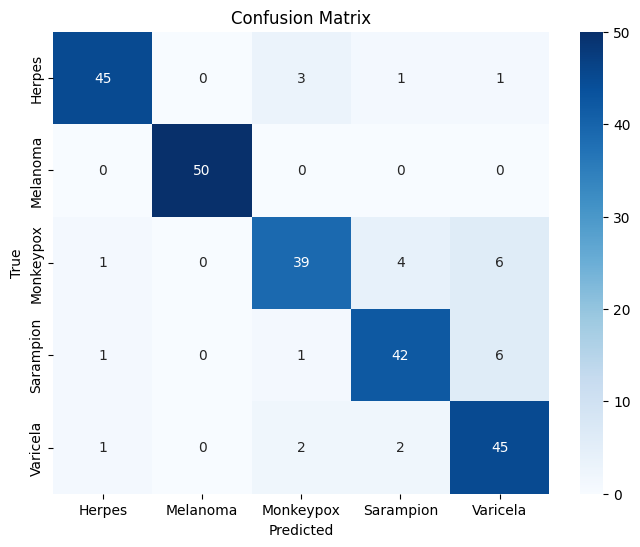

Precision of the MLP :	0.8874343185550082
Recall of the MLP    :	0.884
F1 Score of the Model :	0.8842476320671808
Accuracy: 88.4%


In [38]:
# Calculate Validation Accuracy, Matrix, and Metrics
confusion_matrix_and_metrics(vit_b, val_dataloader, device)
calculate_accuracy(vit_b, val_dataloader, device)

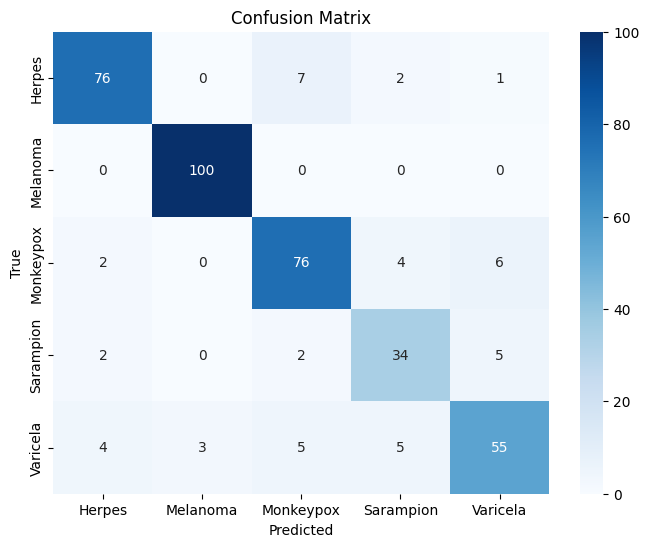

Precision of the MLP :	0.8593062427115463
Recall of the MLP    :	0.8603887714352829
F1 Score of the Model :	0.8594732170814854
Accuracy: 87.66066838046272%


In [39]:
# Calculate Test Accuracy, Matrix, and Metrics
confusion_matrix_and_metrics(vit_b, test_dataloader, device)
calculate_accuracy(vit_b, test_dataloader, device)

In [48]:
# Declare Data Efficient Image Transformer (DeiT)
#!pip install timm
import timm

deit = timm.create_model("deit_base_patch16_224", pretrained=True)
deit.head = nn.Linear(deit.head.in_features, 5, bias=True)
deit = deit.to(device)

In [49]:
deit = torch.load('trained_deit.pth', weights_only=False, map_location=torch.device('cpu'))
deit.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

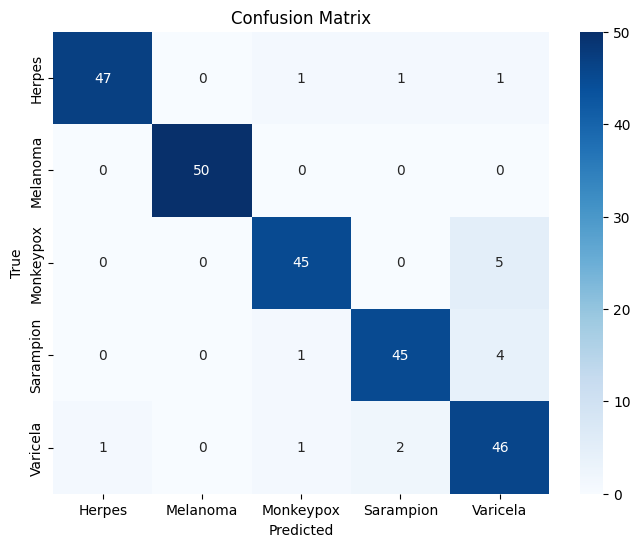

Precision of the MLP :	0.9351190476190476
Recall of the MLP    :	0.932
F1 Score of the Model :	0.9327685791297651
Accuracy: 93.2%


In [52]:
# Calculate Validation Accuracy, Matrix, and Metrics
confusion_matrix_and_metrics(deit, val_dataloader, device)
calculate_accuracy(deit, val_dataloader, device)

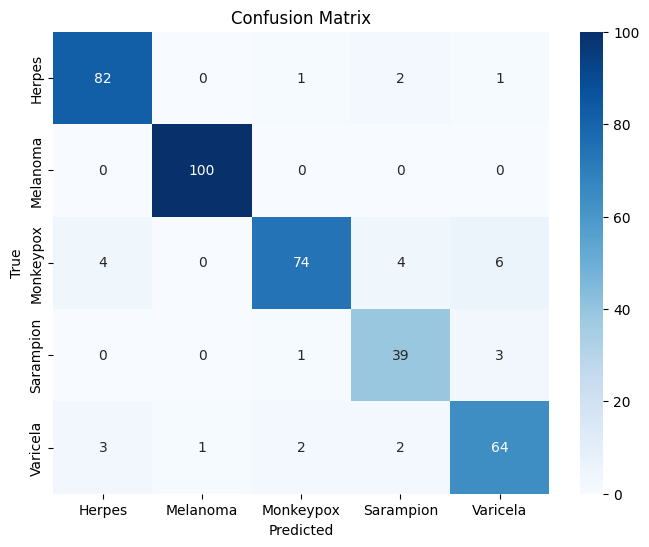

Precision of the MLP :	0.9109634744266197
Recall of the MLP    :	0.9180526192154097
F1 Score of the Model :	0.9134225986517557
Accuracy: 92.2879177377892%


In [53]:
# Calculate Test Accuracy, Matrix, and Metrics
confusion_matrix_and_metrics(deit, test_dataloader, device)
calculate_accuracy(deit, test_dataloader, device)